# testing perturbations in correllated uncertainty

In [1]:
import unittest as ut

import cantera as ct
import numpy as np
from torch.quasirandom import SobolEngine
from rmgpy.data.thermo import ThermoDatabase
from rmgpy.data.kinetics.database import KineticsDatabase
from rmgpy.data.surface import MetalDatabase

from IPython.display import Image
import seaborn as sns
import pickle
import os

sns.set_palette('Dark2')

In [2]:
with open('../../uncertainty_output_folder/sobol_map.pickle', 'rb') as f:
    sobol_map = pickle.load(f)

In [3]:
# Perturbation ranges FOR values (reference value +/- value below)
DELTA_ALPHA_MAX_KN = 0.15
DELTA_E0_MAX_J_MOL_KN = 30000  # 3 eV is about 30000 J/mol
DELTA_A_MAX_EXP_KN = 1
DELTA_STICK_MAX_KN = 0.5 # for sticking coefficient, perturb from 0-1 but by exponent.
DELTA_N_MAX_J_MOL_KN  = 1 

# Perturbation ranges for unknown values (reference value +/- value below)
DELTA_ALPHA_MAX_UNK = 0.5 #start value at 0.5 and perturb from 0-1
DELTA_E0_MAX_J_MOL_UNK = 100000  # 1 eV is about 100,000 J/mol. make sure eV is never 0.
DELTA_A_MAX_EXP_UNK = 4 # for sticking coefficient, perturb from 0-1 but by exponent. 
DELTA_STICK_MAX_UNK = 0.5 # for sticking coefficient
DELTA_N_MAX_J_MOL_UNK  = 1  

# Thermo Perturbations
DELTA_E0_H = 30000
DELTA_E0_C = 30000
DELTA_E0_O = 30000
DELTA_E0_N = 30000
DELTA_E0_VDW = 20000

## sobol sequence testing

In [4]:
# Create the pseudo randoms
N = 10
sobol = SobolEngine(dimension=300, scramble=True, seed=100)
x_sobol = sobol.draw(N)

### get perturbed values so we know we are applying them correctly

In [5]:
pert = 3
perturb = f"000{pert}"

E_0_c = float(DELTA_E0_C - 2.0 * x_sobol[pert,sobol_map["C"][0]] * DELTA_E0_C)/9.6e4
E_0_o = float(DELTA_E0_O - 2.0 * x_sobol[pert,sobol_map["O"][0]] * DELTA_E0_H)/9.6e4
E_0_h = float(DELTA_E0_H - 2.0 * x_sobol[pert,sobol_map["H"][0]] * DELTA_E0_H)/9.6e4
E_0_vdw = float(DELTA_E0_VDW  - 2.0 * x_sobol[pert, sobol_map["Vdw"][0]] * DELTA_E0_VDW)/9.6e4
E_0_n = float(DELTA_E0_N - 2.0 * x_sobol[pert,sobol_map["N"][0]] * DELTA_E0_N)/9.6e4

print(f"C: {E_0_c}\nO: {E_0_o}\nH: {E_0_h}\nVdw: {E_0_vdw}\nN: {E_0_n}")

C: -0.2672578125
O: -0.13855118815104167
H: -0.18107861328125
Vdw: 0.17109051513671875
N: 0.14856981404622396


### make sure our sobol_map matches

In [6]:
E_0_c = sobol_map["C"][1][pert]/9.6e4
E_0_o = sobol_map["O"][1][pert]/9.6e4
E_0_h = sobol_map["H"][1][pert]/9.6e4
E_0_n = sobol_map["N"][1][pert]/9.6e4
E_0_vdw = sobol_map["Vdw"][1][pert]/9.6e4


print(f"C: {E_0_c}\nO: {E_0_o}\nH: {E_0_h}\nVdw: {E_0_vdw}\nN: {E_0_n}")

C: -2.6725779207481537e-06
O: -1.3855118368155672e-06
H: -1.8107863297700533e-06
Vdw: 0.1710905134677887
N: 1.4856982488709036e-06


In [7]:
os.path.abspath("../../RMG-database/input/surface/libraries/metal_0001.py")

'/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/RMG-database/input/surface/libraries/metal_0001.py'

### Metal DB

In [8]:
mdb_orig = MetalDatabase()
mdb_orig.load("../../RMG-database/input/surface/")

In [9]:
metal_library_path = f"../../uncertainty_output_folder/db_{perturb}/input/surface/"
mdb_new = MetalDatabase()
mdb_new.load(metal_library_path)

In [10]:
mdb_orig.find_binding_energies("Cu111")

{'H': (-2.58383,'eV/molecule'),
 'C': (-4.96034,'eV/molecule'),
 'N': (-3.58447,'eV/molecule'),
 'O': (-4.20764,'eV/molecule')}

In [11]:
mdb_new.find_binding_energies("Cu111")

{'H': (-2.75767,'eV/molecule'),
 'C': (-5.21691,'eV/molecule'),
 'N': (-3.44184,'eV/molecule'),
 'O': (-4.34065,'eV/molecule')}

check metal BE perturbations and make sure they are correct

### thermo base

In [13]:
rmg_thermo_pt111 = ThermoDatabase()
library_path = "../../RMG-database/input/thermo/"
thermo_libraries = ["surfaceThermoPt111"]
rmg_thermo_pt111.load(
    library_path,
    libraries=thermo_libraries,
    depository=False,
    surface=True)
thermo_pt_base = rmg_thermo_pt111.libraries["surfaceThermoPt111"]

### thermo perturbed 

In [14]:
rmg_thermo_pt111_0001 = ThermoDatabase()
library_path = f"../../uncertainty_output_folder/db_{perturb}/input/thermo/"
thermo_libraries = ["surfaceThermoPt111"]

rmg_thermo_pt111_0001.load(
    library_path,
    libraries=thermo_libraries,
    depository=False,
    surface=True)
thermo_pt_0001 = rmg_thermo_pt111_0001.libraries["surfaceThermoPt111"]

In [15]:
thermo = thermo_pt_base

In [16]:
import glob
import os
reference_db = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/RMG-database/"
perturbed_kinetics_libs = glob.glob(os.path.join(reference_db, 'input', 'kinetics','libraries', 'Surface', '**', '*0000.py'), recursive=True)
perturbed_kinetics_libs 

['/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/RMG-database/input/kinetics/libraries/Surface/CPOX_Pt/Deutschmann2006_adjusted/reactions_0000.py']

In [17]:
pth = os.path.join(reference_db, 'input', 'kinetics','libraries','**','reactions_0000.py')
pth

'/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/RMG-database/input/kinetics/libraries/**/reactions_0000.py'

### Specify kinetic families that were perturbed

In [18]:
kinetics_libraries = [
    'CPOX_Pt/Deutschmann2006_adjusted',
]

kinetics_families_dict = { # list the families to perturb
        "Surface_Abstraction":[],
        "Surface_Abstraction_Beta":[],
        "Surface_Abstraction_Beta_double_vdW":[],
        "Surface_Abstraction_Beta_vdW":[],
        "Surface_Abstraction_Single_vdW":[1,],
        "Surface_Abstraction_vdW":[1,],
        "Surface_Addition_Single_vdW":[1,],
        "Surface_Adsorption_Abstraction_vdW":[1,],
        "Surface_Adsorption_Bidentate":[1, ],
        "Surface_Adsorption_Dissociative":[1, ], # top level node is a guess, but subnodes are slightly better
        "Surface_Adsorption_Dissociative_Double":[1, ],
        "Surface_Adsorption_Double":[1,],
        "Surface_Adsorption_Single":[1,],
        "Surface_Adsorption_vdW":[1,],
        "Surface_Bidentate_Dissociation":[],
        "Surface_Dissociation":[],
        "Surface_Dissociation_Beta":[],
        "Surface_Dissociation_Beta_vdW":[],
        "Surface_Dissociation_Double":[],
        "Surface_Dissociation_Double_vdW":[1, ],
        "Surface_Dissociation_vdW":[],
        "Surface_DoubleBond_to_Bidentate":[],
        "Surface_Dual_Adsorption_vdW":[1,],
        "Surface_EleyRideal_Addition_Multiple_Bond":[1,],
        "Surface_Migration":[1,],
        "Surface_vdW_to_Bidentate":[1,],
}

# make a list of just kinetics families for convenience
kinetics_families = list(kinetics_families_dict.keys())

### kinetic base 

In [19]:
families_dir_base = "../../RMG-database/input/kinetics/families/"
kinetic_libraries_dir_base = "../../RMG-database/input/kinetics/libraries/Surface/"

kinetics_database_base = KineticsDatabase()
kinetics_database_base.load_families(
    path=families_dir_base,
    families=kinetics_families,
)
kinetics_database_base.load_libraries(
    kinetic_libraries_dir_base,
    libraries=kinetics_libraries
)

### kinetic perturbed

In [20]:
families_dir_pert = f"../../uncertainty_output_folder/db_{perturb}/input/kinetics/families/"
kinetic_libraries_dir_pert = f"../../uncertainty_output_folder/db_{perturb}/input/kinetics/libraries/Surface/"

kinetics_database_pert = KineticsDatabase()
kinetics_database_pert.load_families(
    path=families_dir_pert,
    families=kinetics_families,
)

kinetics_database_pert.load_libraries(
    kinetic_libraries_dir_pert,
    libraries=kinetics_libraries
)

### compare Pt lib values

#### vdw

In [21]:
species = "H2_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("original in eV: ",(h1/9.6e4))
print("perturbed in eV: ",(h2/9.6e4))
print("perturbation in eV: ",(h2-h1)/9.6e4)

assert np.isclose(E_0_vdw, (h2-h1)/9.6e4)

original in eV:  -0.06109337939279112
perturbed in eV:  0.10999714872779898
perturbation in eV:  0.17109052812059009


In [22]:
species = "H2O_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("original in eV: ",(h1)/9.6e4)
print("perturbed in eV: ",(h2/9.6e4))
print("perturbation in eV: ",(h2-h1)/9.6e4)
vdw_perturb = (h2-h1)/9.6e4

assert np.isclose(E_0_vdw, vdw_perturb)

original in eV:  -2.7443305972034606
perturbed in eV:  -2.57323909790175
perturbation in eV:  0.17109149930171072


same for vdw species

#### carbon

In [23]:
species = "CH_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)
assert np.isclose(E_0_c, (h2-h1)/9.6e4)

perturbation in eV:  -2.9741160259770065e-07


AssertionError: 

In [ ]:
species = "C-CH2_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

c_perturb = (h2-h1)/9.6e4

assert np.isclose(E_0_c, (h2-h1)/9.6e4)

same for carbon species

#### oxygen

In [ ]:
species = "O_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

In [ ]:
species = "OOH_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

In [ ]:
species = "O-CH3_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

o_perturb = (h2-h1)/9.6e4

#### hydrogen (only one)

In [ ]:
species = "H_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

### bidentates

In [ ]:
species = "CH-CH_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

In [ ]:
c_perturb*2

In [ ]:
species = "HCO-h_ads"
file = species + ".png"
thermo.entries[species].item.draw(file)
display((Image(filename=file)))

h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)
h2 = thermo_pt_0001.entries[species].data.get_enthalpy(298)

print("perturbation in eV: ",(h2-h1)/9.6e4)

In [ ]:
c_perturb+o_perturb

### test groups

In [ ]:
rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries

carbon

In [ ]:
species = "C#*R"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("library perturbation, Carbon: ", c_perturb)

In [ ]:
species = "O-*OR"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("library perturbation, Oxygen: ", o_perturb)

vdw

In [ ]:
species = "(CRN)*"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("library perturbation, vdW: ", vdw_perturb)

bidentate

make sure we add perturbations per each bonded atom. probably not necessary since we don't have any in model

In [ ]:
species = "C-*RC=*"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("perturbation from each bound c", c_perturb*2)

averaged

make sure that R\*bidentate and R\*single_chemisorbed are averaged properly

In [ ]:
species = "R*bidentate"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("perturbation avg from C*3 and N in eV: ",np.average([E_0_c, E_0_c,E_0_c,E_0_n])*2)

In [ ]:
species = "R*single_chemisorbed"
file = species + ".png"
with open(file, "wb") as img:
    img.write(rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].item.draw('png'))
    
display((Image(filename=file)))

h1 = rmg_thermo_pt111.groups['adsorptionPt111'].entries[species].data.H298.value_si
h2 = rmg_thermo_pt111_0001.groups['adsorptionPt111'].entries[species].data.H298.value_si

print("perturbation in eV: ",(h2-h1)/9.6e4)
print("perturbation avg from C*3 and N in eV: ",np.average([E_0_c, E_0_o,E_0_n]))

## load the cantera file and ensure that perturbation for species match what we expect

In [ ]:
# cantera_file = f"../../uncertainty_output_folder/run_{perturb}/cantera/chem_annotated.cti"
# gas = ct.Solution(cantera_file)
# surf = ct.Interface(cantera_file, "surface1", [gas])

enthalpies are in j/kmol in cantera, multiply by kmol/1e3 mol and divide by 9.6e4 J/eV

In [ ]:
# perturb

In [ ]:
# species = "CO-f_ads"
# file = species + ".png"
# thermo.entries[species].item.draw(file)
# display((Image(filename=file)))

# h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)/9.6e4
# h2 = surf.species("OCX(22)").thermo.h(298)/1e3/9.6e4

# print("perturbation in eV: ",(h2-h1))

In [ ]:
# def show_species_atoms(phase, spec):
#     n_H = phase.n_atoms(spec, "H")
#     n_C = phase.n_atoms(spec, "C")
#     n_O = phase.n_atoms(spec, "O")
#     n_X = phase.n_atoms(spec, "X")
    
#     atom_dict = {
#         "H":n_H,
#         "C":n_C,
#         "O":n_O,
#         "X":n_X,
#     }
    
#     return atom_dict

# atoms_spec = show_species_atoms(surf, "OCX(22)")
# print(atoms_spec)

In [ ]:
# species = "CO-f_ads"
# file = species + ".png"
# thermo.entries[species].item.draw(file)
# display((Image(filename=file)))

In [ ]:
# thermo.entries

In [ ]:
# BE_o_pt = -3.81153
# Be_o_cu = -4.20764


In [ ]:
# species = "O_ads"
# file = species + ".png"
# thermo.entries[species].item.draw(file)
# display((Image(filename=file)))

# h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)/9.6e4
# h2 = surf.species("O*(11)").thermo.h(298)/1e3/9.6e4

# print("perturbation in eV: ",(h2-h1))
# h2

In [ ]:
# species = "H2O_ads"
# file = species + ".png"
# thermo.entries[species].item.draw(file)
# display((Image(filename=file)))

# h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)/9.6e4
# h2 = surf.species("H2O*(13)").thermo.h(298)/1e3/9.6e4

# print("original in eV: ",h1)
# print("final in eV:    ",h2)
# print("perturbation in eV: ",(h2-h1))

In [ ]:
# species = "CO2_ads"
# file = species + ".png"
# thermo.entries[species].item.draw(file)
# display((Image(filename=file)))

# h1 = thermo_pt_base.entries[species].data.get_enthalpy(298)/9.6e4
# h2 = surf.species("CO2*(15)").thermo.h(298)/1e3/9.6e4

# print("original in eV: ",h1)
# print("final in eV:    ",h2)
# print("perturbation in eV: ",(h2-h1))

## Kinetic perturbations

### check family values
first, a known family with surfaceArrhenius values

In [ ]:
def perturb_a(A,p):
    DELTA_A_MAX_EXP = 1
    delta_A0 = DELTA_A_MAX_EXP - 2.0 * p * DELTA_A_MAX_EXP
    print("deltaA", delta_A0)
    A_perturbed = A*10**delta_A0
    
    return A_perturbed

# first item is A - factor perturbation
item = 1
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
A_ref = kinetics_database_base.families[fam].rules.entries[grp][0].data.A.value
A_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.A.value

# check that our sobol map gives the right value: 
sobol_map_A_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_A_pert = perturb_a(A_ref,float(x_sobol[pert,item]))

print("original A: ","{:2e}".format(A_ref))
print("final in A:    ","{:2e}".format(A_pert))
print("sobol_map A perturbed:", "{:2e}".format(sobol_map_A_pert))
print("sobol_map A perturbed:", "{:2e}".format(x_sobol_A_pert))

In [ ]:
def perturb_E(E,p):
    DELTA_E0_MAX_J_MOL = 30000 
    delta_E0 = DELTA_E0_MAX_J_MOL - 2.0 * p * DELTA_E0_MAX_J_MOL
    E_perturbed = E+delta_E0
    print("delta_E0 : ",delta_E0 )
    return E_perturbed

# first item is A - factor perturbation
item = 2
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
E_ref = kinetics_database_base.families[fam].rules.entries[grp][0].data.E0.value_si
E_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.E0.value_si

# check that our sobol map gives the right value: 
sobol_map_E_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_E_pert = perturb_E(E_ref,float(x_sobol[pert,item]))

print("original E: ","{:2e}".format(E_ref))
print("final E:    ","{:2e}".format(E_pert))
print("sobol_map E perturbed:", "{:2e}".format(sobol_map_E_pert))
print("sobol_map E perturbed:", "{:2e}".format(x_sobol_E_pert))

In [ ]:
item = 2
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

In [ ]:
def perturb_al(al,p):
    DELTA_ALPHA_MAX = 0.15
    delta_al = DELTA_ALPHA_MAX - 2.0 * p * DELTA_ALPHA_MAX
    al_perturbed = al+delta_al
    
    return al_perturbed

# first item is A - factor perturbation
item = 3
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
al_ref = kinetics_database_base.families[fam].rules.entries[grp][0].data.alpha.value_si
al_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.alpha.value_si

# check that our sobol map gives the right value: 
sobol_map_al_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_al_pert = perturb_al(al_ref,float(x_sobol[pert,item]))

print("original alpha: ","{:2e}".format(al_ref))
print("final alpha:    ","{:2e}".format(al_pert))
print("sobol_map alpha perturbed:", "{:2e}".format(sobol_map_al_pert))
print("x_sobol alpha perturbed:", "{:2e}".format(x_sobol_al_pert))

### check family values
next, a unknown family with surface arrhenius A

In [ ]:
item = 74
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

In [ ]:
def perturb_a(A,p):
    delta_A0 = DELTA_STICK_MAX_KN - 2.0 * p * DELTA_STICK_MAX_KN
    print("deltaA", delta_A0)
    A_perturbed = A + delta_A0
    
    return A_perturbed

# first item is A - factor perturbation
item = 73
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
# A_ref = kinetics_database_base.families[fam].rules.entries[grp][0].data.A.value
A_ref = 0.5
A_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.A.value

# check that our sobol map gives the right value: 
sobol_map_A_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_A_pert = perturb_a(A_ref,float(x_sobol[pert,item]))

print("original A: ","{:2e}".format(A_ref))
print("final in A:    ","{:2e}".format(A_pert))
print("sobol_map A perturbed:", "{:2e}".format(sobol_map_A_pert))
print("sobol_map A perturbed:", "{:2e}".format(x_sobol_A_pert))

now, an unknown alpha

In [ ]:
def perturb_al(al,p):
    delta_al = DELTA_ALPHA_MAX_UNK - 2.0 * p * DELTA_ALPHA_MAX_UNK
    al_perturbed = al+delta_al
    
    return al_perturbed

# first item is A - factor perturbation
item = 72
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
al_ref = 0.5
al_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.alpha.value_si

# check that our sobol map gives the right value: 
sobol_map_al_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_al_pert = perturb_al(al_ref,float(x_sobol[pert,item]))

print("original alpha: ","{:2e}".format(al_ref))
print("final alpha:    ","{:2e}".format(al_pert))
print("sobol_map alpha perturbed:", "{:2e}".format(sobol_map_al_pert))
print("x_sobol alpha perturbed:", "{:2e}".format(x_sobol_al_pert))

now, an unknown E0

In [ ]:
def perturb_E(E,p):
    delta_E0 = DELTA_E0_MAX_J_MOL_UNK - 2.0 * p * DELTA_E0_MAX_J_MOL_UNK
    E_perturbed = E+delta_E0
    print("delta: ", delta_E0)
    return E_perturbed

# first item is A - factor perturbation
item = 74
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

fam,grp,par = sobol_key.split("/")
# E_ref = kinetics_database_base.families[fam].rules.entries[grp][0].data.E0.value_si
E_ref = 100000
E_pert = kinetics_database_pert.families[fam].rules.entries[grp][0].data.E0.value_si

# check that our sobol map gives the right value: 
sobol_map_E_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_E_pert = perturb_E(E_ref,float(x_sobol[pert,item]))

print("original E: ","{:2e}".format(E_ref))
print("final E:    ","{:2e}".format(E_pert))
print("sobol_map E perturbed:", "{:2e}".format(sobol_map_E_pert))
print("sobol_map E perturbed:", "{:2e}".format(x_sobol_E_pert))

### check library values

In [ ]:
def perturb_a(A,p):
    DELTA_A_MAX_EXP = 1
    delta_A0 = DELTA_A_MAX_EXP - 2.0 * p * DELTA_A_MAX_EXP
    print("deltaA: ", delta_A0)
    A_perturbed = A*10**delta_A0
    
    return A_perturbed

# first item is A - factor perturbation
item = 166
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

lib1, lib2, rxn_num, rxn, par, = sobol_key.split("/")
lib = lib1+ "/" + lib2
rxn_num = int(rxn_num)

A_ref = kinetics_database_base.libraries[lib].entries[rxn_num].data.A.value_si

# the reaction labels get mixed around when you resave the database. 
for k, v in kinetics_database_pert.libraries[lib].entries.items():
    if kinetics_database_base.libraries[lib].entries[rxn_num].label in v.label:
        A_pert = kinetics_database_pert.libraries[lib].entries[k].data.A.value_si

# check that our sobol map gives the right value: 
sobol_map_A_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_A_pert = perturb_a(A_ref,float(x_sobol[pert,item]))

print("original A: ","{:2e}".format(A_ref))
print("final in A:    ","{:2e}".format(A_pert))
print("sobol_map A perturbed:", "{:2e}".format(sobol_map_A_pert))
print("x_sobol A perturbed:", "{:2e}".format(x_sobol_A_pert))

In [ ]:
def perturb_E(E,p):
    DELTA_E0_MAX_J_MOL = 30000 
    delta_E0 = DELTA_E0_MAX_J_MOL - 2.0 * p * DELTA_E0_MAX_J_MOL
    E_perturbed = E+delta_E0
    
    return E_perturbed

# first item is A - factor perturbation
item = 167
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

lib1, lib2, rxn_num, rxn, par, = sobol_key.split("/")
lib = lib1+ "/" + lib2
rxn_num = int(rxn_num)

E_ref = kinetics_database_base.libraries[lib].entries[rxn_num].data.Ea.value_si

# the reaction labels get mixed around when you resave the database. 
for k, v in kinetics_database_pert.libraries[lib].entries.items():
    if kinetics_database_base.libraries[lib].entries[rxn_num].label in v.label:
        E_pert = kinetics_database_pert.libraries[lib].entries[k].data.Ea.value_si


# check that our sobol map gives the right value: 
sobol_map_E_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_E_pert = perturb_E(E_ref,float(x_sobol[pert,item]))

print("original E: ","{:2e}".format(E_ref))
print("final in E:    ","{:2e}".format(E_pert))
print("sobol_map E perturbed:", "{:2e}".format(sobol_map_E_pert))
print("x_sobol E perturbed:", "{:2e}".format(x_sobol_E_pert))

check sticking coefficient library A

In [ ]:
item = 154
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

In [ ]:
def perturb_a(A,p):
    DELTA_A_MAX_EXP = 1
    delta_A0 = DELTA_STICK_MAX_KN - 2.0 * p * DELTA_STICK_MAX_KN
    print("deltaA: ", delta_A0)
    A_perturbed = A+delta_A0
    
    return A_perturbed

# first item is A - factor perturbation
item = 154
sobol_key = list(sobol_map.keys())[item]
print(sobol_key)

lib1, lib2, rxn_num, rxn, par, = sobol_key.split("/")
lib = lib1+ "/" + lib2
rxn_num = int(rxn_num)

# A_ref = kinetics_database_base.libraries[lib].entries[rxn_num].data.A.value_si
A_ref = 0.5

# the reaction labels get mixed around when you resave the database. 
for k, v in kinetics_database_pert.libraries[lib].entries.items():
    if kinetics_database_base.libraries[lib].entries[rxn_num].label in v.label:
        A_pert = kinetics_database_pert.libraries[lib].entries[k].data.A.value_si

# check that our sobol map gives the right value: 
sobol_map_A_pert = sobol_map[sobol_key][1][pert]


# check that the value reflects the sobol matrix and was not overwritten
x_sobol_A_pert = perturb_a(A_ref,float(x_sobol[pert,item]))

print("original A: ","{:2f}".format(A_ref))
print("final in A:    ","{:2f}".format(A_pert))
print("sobol_map A perturbed:", "{:2f}".format(sobol_map_A_pert))
print("x_sobol A perturbed:", "{:2f}".format(x_sobol_A_pert))

### black box testing 
check output from RMG run in a chemkin file and ensure perturbs were applied correctly

In [13]:
import rmgpy.chemkin as chmkn

In [14]:
orig_chmkn_path = f"../../uncertainty_output_folder/baseline/chemkin/"
orig_file_surf = orig_chmkn_path + "chem_annotated-surface.inp"
orig_file_gas = orig_chmkn_path +  "chem_annotated-gas.inp"
orig_file_dict = orig_chmkn_path +  "species_dictionary.txt"
orig_model = chmkn.load_chemkin_file(orig_file_surf, dictionary_path=orig_file_dict)

In [15]:
pert_chmkn_path = f"../../uncertainty_output_folder/run_{perturb}/chemkin/"
pert_file_surf = pert_chmkn_path + "chem_annotated-surface.inp"
pert_file_gas = pert_chmkn_path +  "chem_annotated-gas.inp"
pert_file_dict = pert_chmkn_path +  "species_dictionary.txt"
pert_model = chmkn.load_chemkin_file(pert_file_surf, dictionary_path=pert_file_dict)

first, take the h2 dissocation rxn (library, stickingcoefficient)

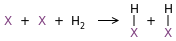

True

In [16]:
# get first rxn from the mechanism
rxn_index = 0
display(orig_model[1][rxn_index])

# ensure it is the same as the first one in the perturbed model
pert_model[1][0].is_isomorphic(orig_model[1][0])

check that the A-factor is perturbed to the correct value. for sticking coefficient reactions this means anywhere from 0-1, independent of original value

In [17]:
a_orig = orig_model[1][rxn_index].kinetics.A
a_pert = pert_model[1][rxn_index].kinetics.A
sobol_pert = sobol_map["CPOX_Pt/Deutschmann2006_adjusted/1/H2 + Pt + Pt <=> HX + HX/A"][1][pert]

print("original: {0} \nPerturbed: {1} \nperturbation_value: {2}".format(a_orig, a_pert, sobol_pert))

original: 0.032 
Perturbed: 0.8992 
perturbation_value: 0.8991646766662598


check that the E0 is perturbed correctly

In [18]:
Ea_orig = orig_model[1][rxn_index].kinetics.Ea.value_si
Ea_pert = pert_model[1][rxn_index].kinetics.Ea.value_si
sobol_pert = sobol_map["CPOX_Pt/Deutschmann2006_adjusted/1/H2 + Pt + Pt <=> HX + HX/Ea"][1][pert]

print("original: {0} \nPerturbed: {1} \nperturbation_value: {2}".format(Ea_orig, Ea_pert, sobol_pert))

original: 0.0 
Perturbed: 18627.168 
perturbation_value: 18627.94921875


library, surface arrhenius

AttributeError: 'tuple' object has no attribute 'value'

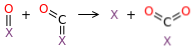

rxn_source: Surface/CPOX_Pt/Deutschmann2006_adjusted


In [19]:
# get first rxn from the mechanism
rxn_index = 7
display(orig_model[1][rxn_index])

# ensure it is the same as the first one in the perturbed model
pert_model[1][rxn_index].is_isomorphic(orig_model[1][rxn_index])

print("rxn_source:", pert_model[1][rxn_index].family)

In [20]:
dir(ut)

['BaseTestSuite',
 'FunctionTestCase',
 'SkipTest',
 'TestCase',
 'TestLoader',
 'TestProgram',
 'TestResult',
 'TestSuite',
 'TextTestResult',
 'TextTestRunner',
 '_TextTestResult',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__unittest',
 'case',
 'defaultTestLoader',
 'expectedFailure',
 'findTestCases',
 'getTestCaseNames',
 'installHandler',
 'load_tests',
 'loader',
 'main',
 'makeSuite',
 'registerResult',
 'removeHandler',
 'removeResult',
 'result',
 'runner',
 'signals',
 'skip',
 'skipIf',
 'skipUnless',
 'suite',
 'util']

In [21]:
sobol_col = 'CPOX_Pt/Deutschmann2006_adjusted/16/OCX + OX <=> CO2X + Pt/Ea'

Ea_orig = orig_model[1][rxn_index].kinetics.Ea.value_si
Ea_pert = pert_model[1][rxn_index].kinetics.Ea.value_si
sobol_pert = sobol_map[sobol_col][1][pert]
sobol_pert_value = x_sobol[pert,sobol_map[sobol_col][0]]
delta_E0 = float(DELTA_E0_MAX_J_MOL_KN - 2.0 * sobol_pert_value * DELTA_E0_MAX_J_MOL_KN)

print("original: {0} \nPerturbed: {1} \nperturbation_value: {2}".format(Ea_orig, Ea_pert, sobol_pert))
print(delta_E0, Ea_pert-Ea_orig)

original: 117599.688 
Perturbed: 128791.888 
perturbation_value: 128792.203125
11192.19921875 11192.200000000012


In [22]:
sobol_col = 'CPOX_Pt/Deutschmann2006_adjusted/16/OCX + OX <=> CO2X + Pt/A'

A_orig = orig_model[1][rxn_index].kinetics.A.value_si
A_pert = pert_model[1][rxn_index].kinetics.A.value_si
sobol_pert = sobol_map[sobol_col][1][pert]
sobol_pert_value = x_sobol[pert,sobol_map[sobol_col][0]]
delta_A = float(DELTA_A_MAX_EXP_KN - 2.0 * sobol_pert_value * DELTA_A_MAX_EXP_KN)
A_perturbed = A_orig*10**delta_A

print("original: {0:e} \nPerturbed: {1:e} \nperturbation_value: {2:e}".format(A_orig, A_pert, sobol_pert))
print(A_perturbed, A_pert-A_orig)
print(orig_model[1][rxn_index].kinetics.A)
print(pert_model[1][rxn_index].kinetics.A)

original: 3.700000e+15 
Perturbed: 9.729780e+15 
perturbation_value: 9.729780e+17
9729780334155516.0 6029780000000002.0
3.7e+21 cm^3/(mol*s)
9.72978e+21 cm^3/(mol*s)


In [33]:
orig_model[1][rxn_index].kinetics.A

(3.7e+21,'cm^3/(mol*s)')

In [23]:
"{0:e}".format(orig_model[1][rxn_index].kinetics.A.value)

'3.700000e+21'

In [24]:
sobol_pert_value

tensor(0.2900)

In [30]:
sobol_map[sobol_col][0]

170

In [31]:

x_sobol[:,sobol_map[sobol_col][0]]

tensor([0.6556, 0.0540, 0.8710, 0.2900, 0.5993, 0.2009, 0.8760, 0.5270, 0.3350,
        0.9991])

In [26]:
sobol_map[sobol_col][1]

tensor([1.8070e+17, 2.8855e+18, 6.7012e+16, 9.7298e+17, 2.3425e+17, 1.4670e+18,
        6.5481e+16, 3.2677e+17, 7.9108e+17, 3.7153e+16])

In [90]:
delta_A = float(DELTA_A_MAX_EXP_KN - 2.0 * sobol_pert_value * DELTA_A_MAX_EXP_KN)
"{0:e}".format(A_orig*10**delta_A)

'9.729780e+15'

In [ ]:
dir(rxn.kinetics.Ea.value_si)

In [ ]:
deut_str = "Surface/CPOX_Pt/Deutschmann2006_adjusted"
for r_i, rxn in enumerate(orig_model[1]):
    # get first rxn from the mechanism
    if rxn.family == deut_str:
        display(rxn)
        
        # ensure it is the same as the first one in the perturbed model
        print(r_i, rxn.is_isomorphic(pert_model[1][r_i]), type(rxn.kinetics))

In [49]:
sobol_map['CPOX_Pt/Deutschmann2006_adjusted/16/OCX + OX <=> CO2X + Pt/Ea'][0]

169

In [35]:
list(sobol_map.keys())

['Surface_Abstraction/Abstracting;Donating/alpha',
 'Surface_Abstraction/Abstracting;Donating/A',
 'Surface_Abstraction/Abstracting;Donating/E0',
 'Surface_Abstraction/Abstracting;*R-H/alpha',
 'Surface_Abstraction/Abstracting;*R-H/A',
 'Surface_Abstraction/Abstracting;*R-H/E0',
 'Surface_Abstraction/O;*C-H/alpha',
 'Surface_Abstraction/O;*C-H/A',
 'Surface_Abstraction/O;*C-H/E0',
 'Surface_Abstraction/O;*OH/alpha',
 'Surface_Abstraction/O;*OH/A',
 'Surface_Abstraction/O;*OH/E0',
 'Surface_Abstraction/C;*C-H/alpha',
 'Surface_Abstraction/C;*C-H/A',
 'Surface_Abstraction/C;*C-H/E0',
 'Surface_Abstraction_Beta/Combined;Adsorbate1/alpha',
 'Surface_Abstraction_Beta/Combined;Adsorbate1/A',
 'Surface_Abstraction_Beta/Combined;Adsorbate1/E0',
 'Surface_Abstraction_Beta/C-H;O/alpha',
 'Surface_Abstraction_Beta/C-H;O/A',
 'Surface_Abstraction_Beta/C-H;O/E0',
 'Surface_Abstraction_Beta/O-H;O/alpha',
 'Surface_Abstraction_Beta/O-H;O/A',
 'Surface_Abstraction_Beta/O-H;O/E0',
 'Surface_Abstraction

In [48]:
x_sobol[3,169]

tensor(0.3135)